In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

#import aparent.visualization as vis

#from aparent_predictor import *


Using TensorFlow backend.


In [2]:
#Store variant prediction dataframe

variant_df = pd.read_csv('aparent_resnet_variant_predictions_polyadb_no_sequences_no_cutoff.csv', sep='\t')


In [3]:
#Load APADB Data and filter on targeted genes

#genes = ['RUNX1', 'CEBPA', 'GATA2', 'ANKRD26', 'DDX41', 'ETV6', 'PTEN', 'BRCA1', 'BRCA2', 'TP53', 'APC', 'ATM', 'PALB2', 'MSH2', 'MLH1', 'MSH6', 'PMS2', 'MUTYH']

polyadb_df = pd.read_csv('polyadb_processed.csv', sep=',')

#polyadb_df = polyadb_df.loc[polyadb_df['gene'].isin(genes)].reset_index(drop=True).copy()
polyadb_df = polyadb_df.loc[((~polyadb_df['gene'].isnull()) & (polyadb_df['gene'] != 'na')) & (polyadb_df['pas'] != -1)].reset_index(drop=True).copy()

print('len(polyadb_df) = ' + str(len(polyadb_df)))


len(polyadb_df) = 175451


In [4]:
#Process PolyaDB data

polyadb_df_minus = polyadb_df.query("strand == '-'").copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df.query("strand == '+'").copy().reset_index(drop=True)

polyadb_df_minus = polyadb_df_minus.sort_values(by='pas_pos', ascending=False).copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df_plus.sort_values(by='pas_pos', ascending=True).copy().reset_index(drop=True)

new_gene_id_list_plus = []
sitenum_list_plus = []
gene_id_dict = {}
for _, row in polyadb_df_plus.iterrows() :

    gene = row['gene']

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_plus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_plus.append(gene_id_dict[gene])

polyadb_df_plus['gene_id'] = new_gene_id_list_plus
polyadb_df_plus['sitenum'] = sitenum_list_plus

new_gene_id_list_minus = []
sitenum_list_minus = []
gene_id_dict = {}
for _, row in polyadb_df_minus.iterrows() :

    gene = row['gene']

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_minus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_minus.append(gene_id_dict[gene])

polyadb_df_minus['gene_id'] = new_gene_id_list_minus
polyadb_df_minus['sitenum'] = sitenum_list_minus

polyadb_df = pd.concat([polyadb_df_plus, polyadb_df_minus])

polyadb_df = polyadb_df.sort_values(by=['gene', 'sitenum'], ascending=True).reset_index(drop=True).copy()

In [5]:
#Get variant positions in hg38 coordinates

polyadb_bed_hg19 = pd.read_csv("polyadb_coordinates_hg19.bed", sep='\t', header=None, names=['chrom', 'pas_pos_hg19', 'end', 'gene', 'gene_id', 'strand'])
polyadb_bed_hg38 = pd.read_csv("polyadb_coordinates_hg38.bed", sep='\t', header=None, names=['chrom', 'pas_pos_hg38', 'end', 'gene', 'gene_id', 'strand'])

polyadb_bed_hg38 = polyadb_bed_hg38.join(polyadb_bed_hg19[['gene_id', 'pas_pos_hg19']].set_index('gene_id'), on='gene_id', how='inner').copy().reset_index(drop=True)

polyadb_bed_hg38['padb_join_id'] = polyadb_bed_hg38['chrom'] + "_" + polyadb_bed_hg38['pas_pos_hg19'].astype(str) + "_" + polyadb_bed_hg38['gene']
polyadb_df['padb_join_id'] = polyadb_df['chrom'] + "_" + polyadb_df['pas_pos'].astype(str) + "_" + polyadb_df['gene']

polyadb_df = polyadb_df.join(polyadb_bed_hg38[['padb_join_id', 'pas_pos_hg38']].set_index("padb_join_id"), on='padb_join_id', how='inner').copy().reset_index(drop=True)

#polyadb_df = polyadb_df.query("site_type == '3_most_exon'")

polyadb_df = polyadb_df.drop_duplicates(subset=['gene_id'], keep='first').copy().reset_index(drop=True)

variant_df = variant_df.join(polyadb_df[['gene_id', 'pas_pos', 'pas_pos_hg38']].set_index("gene_id"), on='gene_id', how='inner').copy().reset_index(drop=True)

variant_df['var_position_hg38'] = variant_df['var_position'] - variant_df['pas_pos'] + variant_df['pas_pos_hg38']


In [6]:
#Get GWAS catalog data

gwas_df = pd.read_csv("gwas_catalog_v1_0_2.tsv", sep='\t')

gwas_df = gwas_df[['CHR_ID', 'CHR_POS', 'STRONGEST SNP-RISK ALLELE', 'P-VALUE', 'PVALUE_MLOG', 'MAPPED_TRAIT']]
gwas_df = gwas_df.loc[gwas_df['STRONGEST SNP-RISK ALLELE'].str.contains("-")].copy().reset_index(drop=True)

gwas_df['SNP_ID'] = gwas_df['STRONGEST SNP-RISK ALLELE'].apply(lambda x: x.split("-")[0])
gwas_df['RISK_ALLELE'] = gwas_df['STRONGEST SNP-RISK ALLELE'].apply(lambda x: x.split("-")[1])

print(len(gwas_df))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (9,12,23,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


292975


In [7]:
#Map variants to gnomAD

gwas_df['gwas_join_id'] = "chr" + gwas_df['CHR_ID'] + "_" + gwas_df['CHR_POS'].astype(str)
variant_df['gwas_join_id'] = variant_df['chrom'] + "_" + variant_df['var_position_hg38'].astype(str)

gwas_df = gwas_df.drop_duplicates(subset=['gwas_join_id'], keep='first').copy().reset_index(drop=True)

variant_df_gwas = variant_df.join(gwas_df[["gwas_join_id", 'P-VALUE', 'PVALUE_MLOG', 'MAPPED_TRAIT', 'SNP_ID', 'RISK_ALLELE']].set_index("gwas_join_id"), on='gwas_join_id', how='inner').copy().reset_index(drop=True)
variant_df_gwas = variant_df_gwas.query("(RISK_ALLELE == var_nucleotide) or (RISK_ALLELE == '?')").copy().reset_index(drop=True)

#variant_df_gwas.to_csv("aparent_resnet_variant_predictions_polyadb_no_sequences_gwas_no_cutoff.csv", sep='\t', index=False)


In [2]:

variant_df_gwas = pd.read_csv("aparent_resnet_variant_predictions_polyadb_no_sequences_gwas_no_cutoff.csv", sep='\t')


n = 1957
n (> 2-fold) = 75


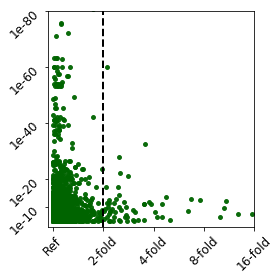

In [3]:
f = plt.figure(figsize=(4, 4))

variant_df_gwas['delta_logodds_77_127_abs'] = np.abs(variant_df_gwas['delta_logodds_77_127'])

print("n = " + str(len(variant_df_gwas)))
print("n (> 2-fold) = " + str(len(variant_df_gwas.query("delta_logodds_77_127_abs > 0.693"))))

plt.scatter(variant_df_gwas['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(variant_df_gwas['P-VALUE'], 1e-200, 1.)) / np.log(10), color='darkgreen', s=15, alpha=0.95)

plt.axvline(x=1., linestyle='--', linewidth=2, color='black')

plt.xlim(-0.1, 4.0)
plt.ylim(3, 80)

plt.xticks([0, 1, 2, 3, 4], ['Ref', '2-fold', '4-fold', '8-fold', '16-fold'], fontsize=12, rotation=45)
plt.yticks([10, 20, 40, 60, 80], ["1e-10", "1e-20", "1e-40", "1e-60", "1e-80", "1e-100"], fontsize=12, rotation=45)

plt.savefig("gwas_aparent_resnet_scatter.png", transparent=True, dpi=300)
plt.savefig("gwas_aparent_resnet_scatter.eps")

plt.tight_layout()

plt.show()

In [4]:

variant_df_gwas = pd.read_csv("aparent_resnet_variant_predictions_polyadb_no_sequences_gwas_no_cutoff.csv", sep='\t')
variant_df_gwas = variant_df_gwas.query("site_type == '3_most_exon'").copy().reset_index(drop=True)


n = 1233
n (> 2-fold) = 49


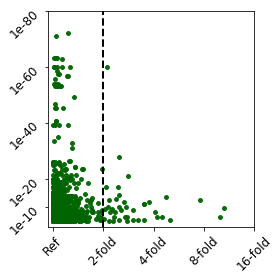

In [5]:
f = plt.figure(figsize=(4, 4))

variant_df_gwas['delta_logodds_77_127_abs'] = np.abs(variant_df_gwas['delta_logodds_77_127'])

print("n = " + str(len(variant_df_gwas)))
print("n (> 2-fold) = " + str(len(variant_df_gwas.query("delta_logodds_77_127_abs > 0.693"))))

plt.scatter(variant_df_gwas['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(variant_df_gwas['P-VALUE'], 1e-200, 1.)) / np.log(10), color='darkgreen', s=15, alpha=0.95)

plt.axvline(x=1., linestyle='--', linewidth=2, color='black')

plt.xlim(-0.1, 4.0)
plt.ylim(3, 80)

plt.xticks([0, 1, 2, 3, 4], ['Ref', '2-fold', '4-fold', '8-fold', '16-fold'], fontsize=12, rotation=45)
plt.yticks([10, 20, 40, 60, 80], ["1e-10", "1e-20", "1e-40", "1e-60", "1e-80", "1e-100"], fontsize=12, rotation=45)

plt.savefig("gwas_aparent_resnet_scatter_utr3_only.png", transparent=True, dpi=300)
plt.savefig("gwas_aparent_resnet_scatter_utr3_only.eps")

plt.tight_layout()

plt.show()

n = 1233
n (> 2-fold) = 49


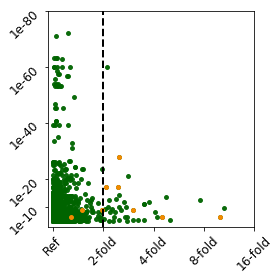

      delta_logodds_77_127  delta_logodds_77_127_abs_log_2       P-VALUE  \
539               -2.29748                        9.949079  3.000000e-07   
540               -1.50624                        4.509742  3.000000e-07   
171                1.10977                        3.033661  1.000000e-09   
567                0.72605                        2.066900  8.000000e-18   
793                0.89808                        2.454885  8.000000e-18   
1223               0.90931                        2.482609  8.000000e-29   

      neg_log_p_val_10                              MAPPED_TRAIT       SNP_ID  
539           6.522879  attention deficit hyperactivity disorder       rs6796  
540           6.522879  attention deficit hyperactivity disorder       rs6796  
171           9.000000             total cholesterol measurement  rs555328608  
567          17.096910                       calcium measurement   rs16833132  
793          17.096910             central nervous system cancer   

In [19]:
f = plt.figure(figsize=(4, 4))

snp_ids = ['rs16833132', 'rs8753', 'rs555328608', 'rs2732480', 'rs555328608', 'rs6796']

variant_df_gwas['delta_logodds_77_127_abs'] = np.abs(variant_df_gwas['delta_logodds_77_127'])

print("n = " + str(len(variant_df_gwas)))
print("n (> 2-fold) = " + str(len(variant_df_gwas.query("delta_logodds_77_127_abs > 0.693"))))

plt.scatter(variant_df_gwas['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(variant_df_gwas['P-VALUE'], 1e-200, 1.)) / np.log(10), color='darkgreen', s=15, alpha=0.95)
plt.scatter(variant_df_gwas.loc[variant_df_gwas['SNP_ID'].isin(snp_ids)]['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(variant_df_gwas.loc[variant_df_gwas['SNP_ID'].isin(snp_ids)]['P-VALUE'], 1e-200, 1.)) / np.log(10), color='darkorange', s=15, alpha=0.95)

plt.axvline(x=1., linestyle='--', linewidth=2, color='black')

plt.xlim(-0.1, 4.0)
plt.ylim(3, 80)

plt.xticks([0, 1, 2, 3, 4], ['Ref', '2-fold', '4-fold', '8-fold', '16-fold'], fontsize=12, rotation=45)
plt.yticks([10, 20, 40, 60, 80], ["1e-10", "1e-20", "1e-40", "1e-60", "1e-80", "1e-100"], fontsize=12, rotation=45)

plt.savefig("gwas_aparent_resnet_scatter_utr3_only_highlighted.png", transparent=True, dpi=300)
plt.savefig("gwas_aparent_resnet_scatter_utr3_only_highlighted.eps")

plt.tight_layout()

plt.show()

#Print highlighted variant details

variant_df_gwas['delta_logodds_77_127_abs_log_2'] = 2**(variant_df_gwas['delta_logodds_77_127_abs'] / np.log(2.))
variant_df_gwas['neg_log_p_val_10'] = -np.log(np.clip(variant_df_gwas['P-VALUE'], 1e-200, 1.)) / np.log(10)

print(variant_df_gwas.loc[variant_df_gwas['SNP_ID'].isin(snp_ids)].query("delta_logodds_77_127_abs_log_2 >= 2.").sort_values(by='neg_log_p_val_10')[['delta_logodds_77_127', 'delta_logodds_77_127_abs_log_2', 'P-VALUE', 'neg_log_p_val_10', 'MAPPED_TRAIT', 'SNP_ID']])
